# iForest

In [1]:
import warnings
warnings.filterwarnings('ignore')

## General libraries

In [2]:
import os
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from os.path import join
import json
import datetime

import time

### Load enviroment variables

In [3]:
from dotenv import load_dotenv
load_dotenv('../.env')

code_root = os.environ['CODE_ROOT']
cfg_path = os.environ['CFG_PATH']
data_root = os.environ['DATA_ROOT']

sys.path.insert(0, code_root)

### Specific libraries

In [4]:
from src.load.functions import get_fs_dataset

### Parameters

In [5]:
seed = 123
np.random.seed(seed)

dataset_id = 'example'
df = get_fs_dataset(dataset_id, data_root)

### Paths

In [6]:
path_fi_shap = os.path.join(data_root, "outputs", f"{dataset_id}_fi_shap")
path_shap = os.path.join(data_root, "outputs", f"{dataset_id}_shap.parquet")

In [7]:
path_fi_shap

'/Users/eduardosepulveda/workspace_github/ad_shap_stability/test/data/outputs/example_fi_shap'

### Read data

In [8]:
featues = pd.read_parquet(path_fi_shap)
df = pd.read_parquet(path_shap)

In [103]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plots_metrics(metrics_df, feat_imp=None, metrics_list=['f1-score', 'recall', 'precision', 'roc_auc', 'smli', 'smli_all'],
                                        x_axis_line_plots=None, x_axis_boxplots=None):
    if feat_imp is not None:
        selected_feats = []
        for imp in feat_imp:
            closest_feat = metrics_df.iloc[(metrics_df['n_features_cum_shap_percentage'] - imp).abs().argsort()[:1]]['n_feat'].values[0]
            selected_feats.append(closest_feat)
        unique_features = sorted(set(selected_feats), reverse=True)
    else:
        unique_features = metrics_df['n_feat'].unique()

    # Set default x-axes if not provided
    if x_axis_line_plots is None:
        x_axis_line_plots = sorted(metrics_df['n_estimators'].unique())
    if x_axis_boxplots is None:
        x_axis_boxplots = sorted(metrics_df['n_estimators'].unique())

    # Determine the number of rows: check if smli_all is in metrics_list
    include_smli_all = 'smli_all' in metrics_list
    non_smli_all_metrics = [m for m in metrics_list if m != 'smli_all']
    total_rows = len(non_smli_all_metrics) + (1 if include_smli_all else 0)  # Adding one row for stability boxplots if smli_all is present

    # Calculate the width of each subplot based on the number of n_estimators
    plot_widths = [len(x_axis_line_plots) / 10 for _ in unique_features]  # Adjust the divisor to scale plot width
    boxplot_widths = [len(x_axis_boxplots) / 10 for _ in unique_features]  # Adjust the divisor to scale plot width
    
    # Set up the figure with varying widths based on n_estimators
    fig, axes = plt.subplots(total_rows, len(unique_features), 
                             figsize=(sum(plot_widths) * 5, 5 * total_rows), 
                             gridspec_kw={'width_ratios': boxplot_widths})

    # Handle cases where there's only one subplot
    if total_rows == 1 and len(unique_features) == 1:
        axes = np.array([axes])
    elif total_rows == 1:
        axes = np.expand_dims(axes, 0)
    elif len(unique_features) == 1:
        axes = np.expand_dims(axes, -1)

    # Create a blue color palette
    blue_palette = sns.color_palette("Blues", n_colors=len(unique_features))

    # Plot the non-smli_all metrics
    for m, metric in enumerate(non_smli_all_metrics):
        for i, n_feat in enumerate(unique_features):
            ax = axes[m, i] if total_rows > 1 else axes[i]
            subset_df = metrics_df[metrics_df['n_feat'] == n_feat]

            # Plotting a line with points connected for metrics
            ax.plot(subset_df['n_estimators'], subset_df[metric], marker='o', linestyle='-', color=blue_palette[i], label=f'{n_feat} Features')

            if m == 0:
                ax.set_title(f'{n_feat} Features')
            if i == 0:
                ax.set_ylabel(metric.replace('_', ' ').capitalize())
            ax.set_xlabel('Number of Estimators' if m == len(non_smli_all_metrics) - 1 else '')
            ax.set_xticks(x_axis_line_plots)
            ax.set_xlim([min(x_axis_line_plots), max(x_axis_line_plots)])
            ax.grid(True)

    # Add the stability boxplots in the last row only if smli_all is in metrics_list
    if include_smli_all:
        stability_row = total_rows - 1
        for i, n_feat in enumerate(unique_features):
            ax = axes[stability_row, i] if len(unique_features) > 1 or total_rows > 1 else axes[0]
            subset_df = metrics_df[metrics_df['n_feat'] == n_feat]

            # Prepare data for boxplot
            plot_data = []
            for n_estimators in x_axis_boxplots:
                # Extract smli_all for the given n_estimators
                smli_values = subset_df[subset_df['n_estimators'] == n_estimators]['smli_all'].values
                if len(smli_values) > 0:
                    plot_data.append(smli_values[0])  # Add the smli_all array directly
                else:
                    plot_data.append([])  # Empty list if no values available

            # Create the boxplot using the prepared data
            sns.boxplot(data=plot_data, ax=ax, palette=blue_palette)
            ax.set_title(f'{n_feat} Features' if stability_row == 0 else "")
            ax.set_xlabel('Number of Estimators')
            ax.set_xticks(range(len(x_axis_boxplots)))
            ax.set_xticklabels(x_axis_boxplots)
            ax.set_xlim([-0.5, len(x_axis_boxplots) - 0.5])  # Set x limits to fit all boxes
            ax.set_ylabel('Stability' if i == 0 else "")
            ax.grid(True)
    
    plt.tight_layout()
    plt.show()

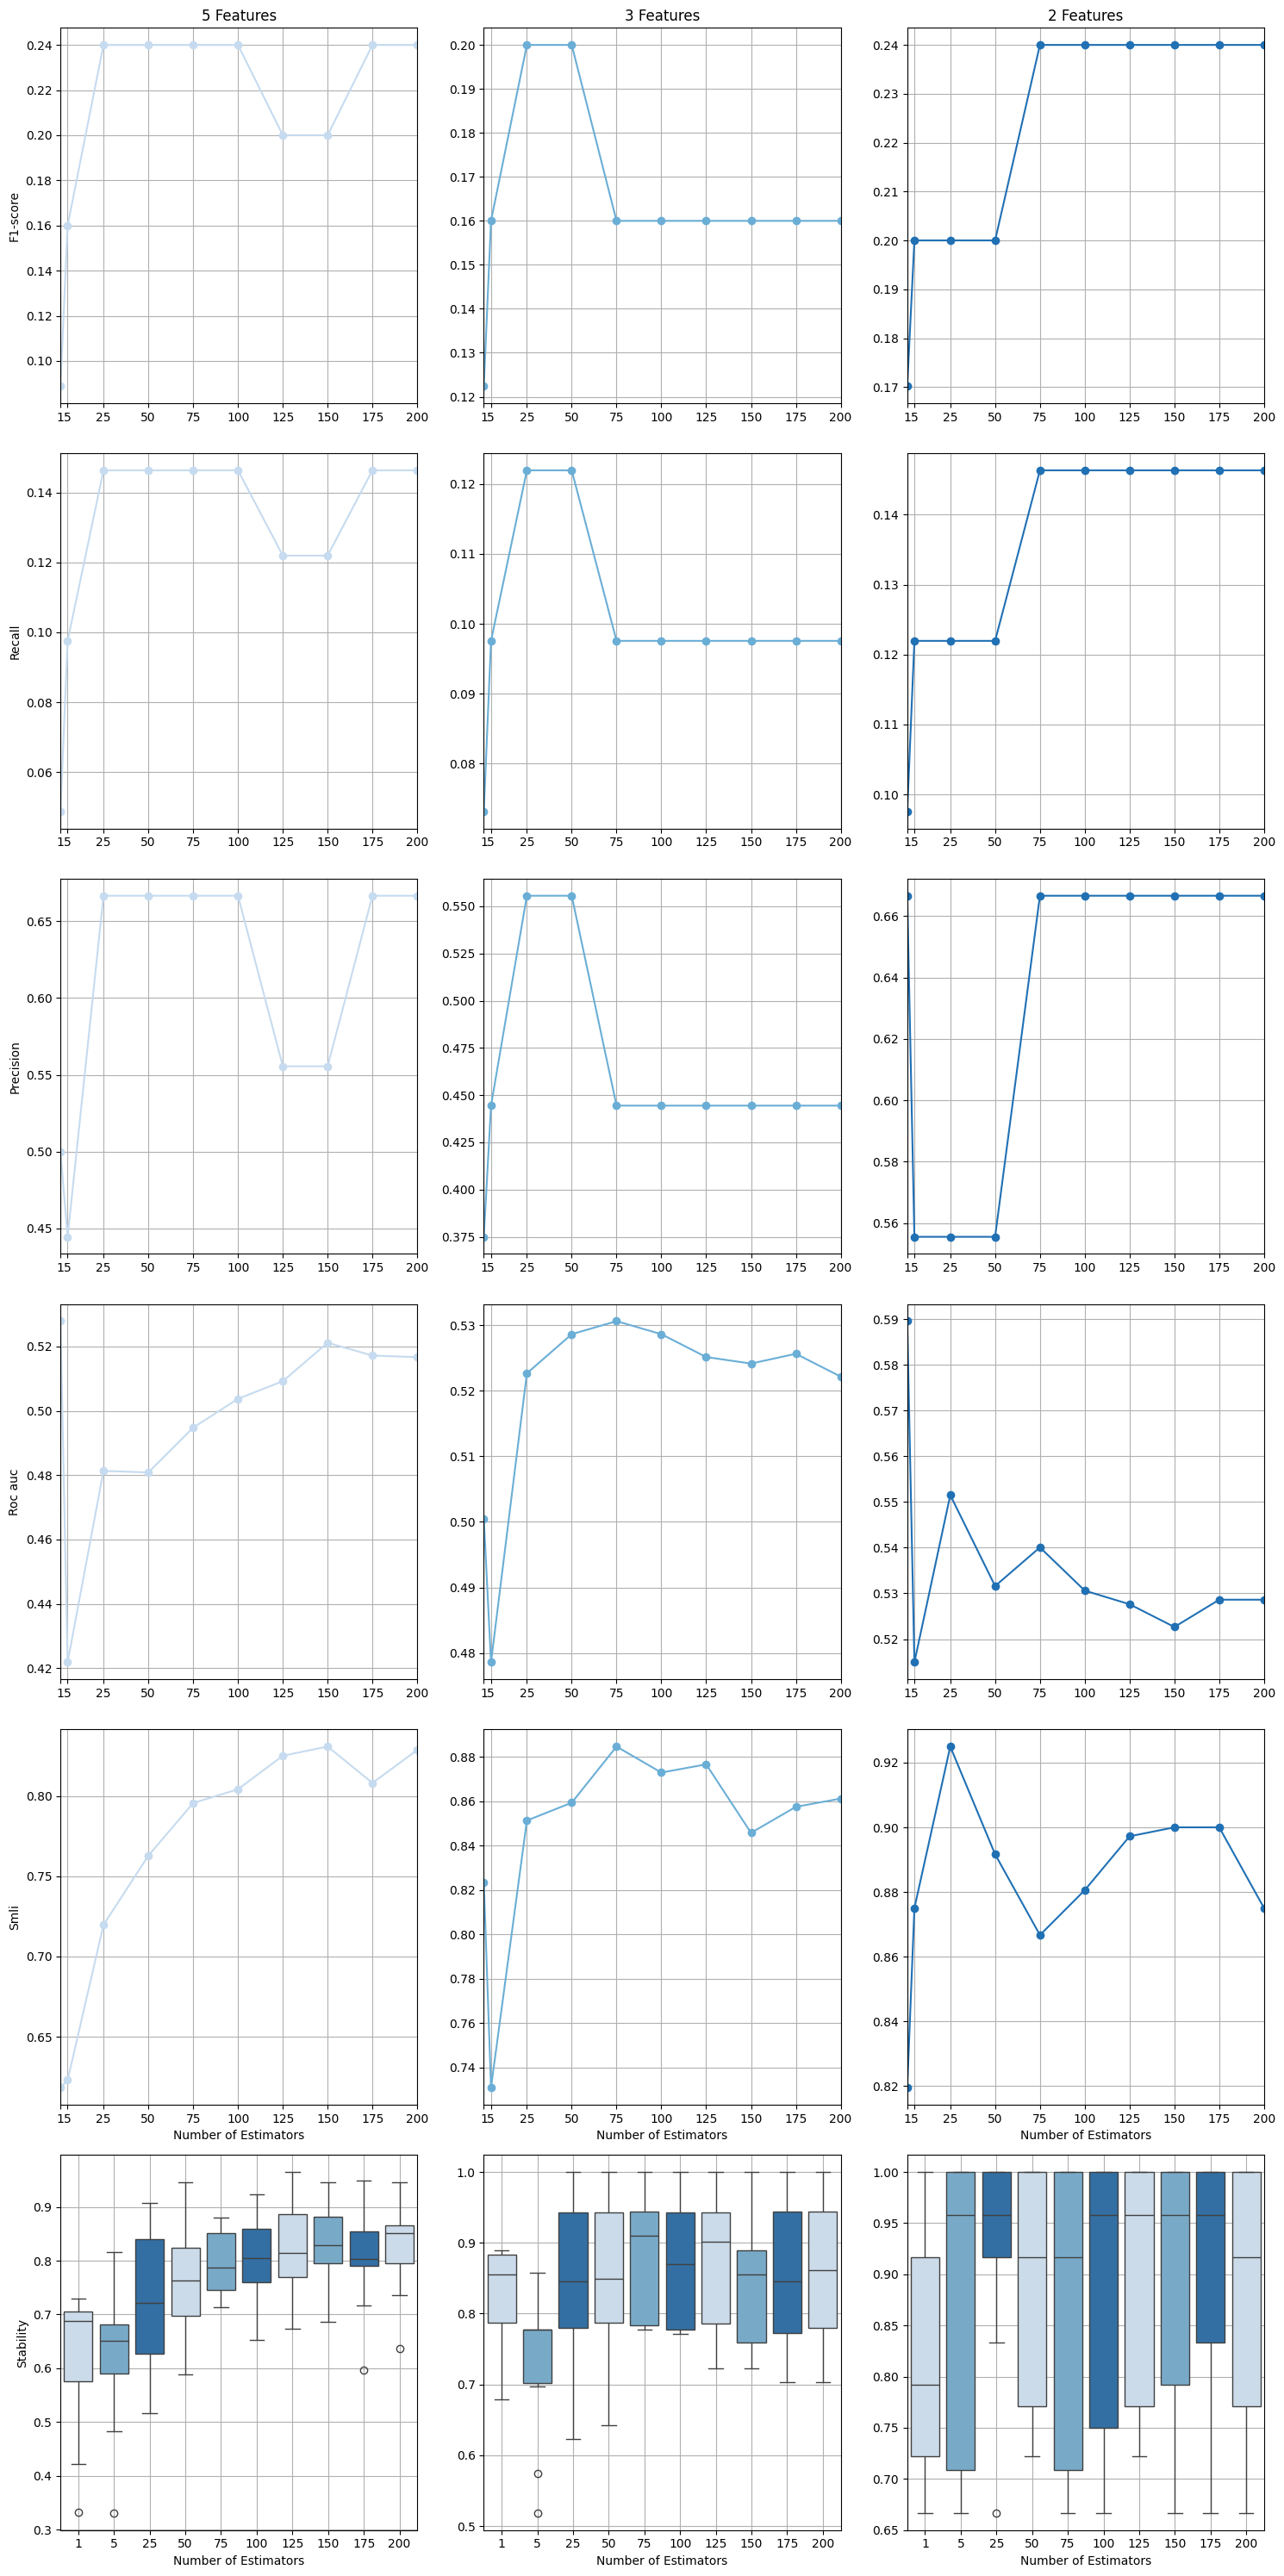

In [106]:
plots_metrics(df, 
              feat_imp=[100, 75, 50, 25],
              metrics_list=['f1-score', 'recall', 'precision', 'roc_auc', 'smli', 'smli_all'])

## Parameters

In [ ]:
path_shap = os.path.join(data_root, "outputs", f"{dataset_id}_shap.parquet")
df = pd.read_parquet(path_shap)

image_1 = os.path.join(data_root, "images", f'3d_precision_{dataset_id}.png')
image_2 = os.path.join(data_root, "images", f'3d_shap_index_{dataset_id}.png')
image_3 = os.path.join(data_root, "images", f'2d_precision_stability_{dataset_id}.png')
image_4 = os.path.join(data_root, "images", f'2d_boxplots_{dataset_id}.png')
image_5 = os.path.join(data_root, "images", f'2d_lineplots_{dataset_id}.png')
image_6 = os.path.join(data_root, "images", f'3d_precision_stability_{dataset_id}.png')

In [ ]:
path_fi_shap = os.path.join(data_root, "outputs", f"{dataset_id}_fi_shap")
path_shap = os.path.join(data_root, "outputs", f"{dataset_id}_shap.parquet")

fi_shap_all = pd.read_parquet(path_fi_shap)
df = pd.read_parquet(path_shap)
df = df[(df.n_estimators>=25) & (df.n_estimators<=600)]

df['shap_q1'] = df['shap_stab'].apply(lambda x: np.percentile(x, 75))
df['shap_q2'] = df['shap_stab'].apply(lambda x: np.percentile(x, 50))
df['shap_q3'] = df['shap_stab'].apply(lambda x: np.percentile(x, 25))

df['shap_ad_q2'] = df['shap_stab_ad'].apply(lambda x: np.percentile(x, 50))
df['stability index'] = df['shap_stab'].apply(lambda x: np.mean(x))

var = ['n_estimators', 'max_feats', 'n_feats', 'f1_median', 'precision', 'recall', 'model_stab', 'shap_stab', 'shap_q2', 'stability index', 'roc_auc']
df = df[var]

## Optimization

In [ ]:
sorted_df = opt_value(df, lambda_=0.7, var2='stability index')

opt_x = int(sorted_df.iloc[0:1,:].n_estimators)
opt_y = int(sorted_df.iloc[0:1,:].n_feats)

sorted_df.head(5)

## Visualization of the results

In [ ]:
# Find the index of the maximum 'n_feat' in each 'n_estimators' and 'n_feats' group
idx = df.groupby(['n_estimators', 'n_feats'])['max_feats'].idxmax()
# Filter the DataFrame to keep only the rows with the maximum 'n_feat' per group
df_n_trees = df.loc[idx].reset_index(drop=True)

In [ ]:
plt.figure(figsize=(9, 3.8))  # Overall figure size

# First plot
ax1 = plt.subplot(1, 2, 1, projection='3d')
plot_3d_surface(df_n_trees, 'n_estimators', 'n_feats', 'precision', ax1, fontsize_title=7, fontsize_axes=6, cmap='YlGnBu', x_step=20, y_step=5, opt_color='red', title='', alpha=0.85, edgecolor=None)

ax2 = plt.subplot(1, 2, 2, projection='3d')
plot_3d_surface(df_n_trees, 'n_estimators', 'n_feats', 'stability index', ax2, fontsize_title=7, fontsize_axes=6, cmap='YlGnBu', x_step=20, y_step=5, opt_color='red', alpha=.9, edgecolor=None)

plt.tight_layout()  # Adjust layout


# Adjust the spacing between the plots
plt.subplots_adjust(wspace=0.1)  # Adjust the width space as needed for better visualization

plt.savefig(image_6, bbox_inches='tight', pad_inches=0.3)  # Save the plot to a file
plt.show()

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(11, 3))  # 1 row, 2 columns

plot_2d_surface(df_n_trees, axs, fontsize_title=12, fontsize_axes=8, save_path=image_3)

In [ ]:
# Sorting the DataFrame
df = df.sort_values(by=['n_estimators', 'n_feats', 'max_feats'], ascending=[True, False, False])

# Preparing subsets
ranks = [1, 2, 4, 6, 8, 10]  # Define ranks of interest
max_feats = [1, 2, 3, 4, 5]  # Define max_feats of interest

# Adding sequences
df = add_custom_repeating_sequence(df, 'rank_max_feats', len(max_feats))
sequence = np.concatenate([np.repeat(i, len(max_feats)) for i in range(1, 12)])  # Creating a sequence from 1 to 11, each repeating 5 times
df = add_sequence_to_dataframe(df, sequence, 'rank_feats')

# Assigning rank based on group
df['rank_estimators'] = df.groupby(['n_feats', 'rank_max_feats']).cumcount() + 1

subsets = prepare_subsets(df, ranks, max_feats)

# Now, you can access your subsets like subsets['df1_1'], subsets['df2_1'], ..., subsets['df10_1'].

In [ ]:
subsets

In [ ]:
# Define your DataFrame for without feature selection `df0` and with feature selection `df1`
fig, axs = plt.subplots(1, 2, figsize=(11, 3))  # Create a figure and a 2x1 grid of subplots

# Call the boxplot_stability function
boxplot_stability(subsets['df1_1'], subsets['df2_1'], axs, fontsize_title=12, fontsize_axes=8, title='Comparison of SHAP Stability', save_path=image_4)

In [ ]:
dataframes = [subsets['df1_1'], subsets['df2_1']] #, df21, df31, df41, df51

fig, axs = plt.subplots(1, 2, figsize=(11, 3))  # Create a figure and a 2x1 grid of subplots

# Assume `dataframes` is a list of DataFrame objects you want to plot
# Call the lineplot_stability function
lineplot_stability(dataframes, axs, fontsize_title=12, fontsize_axes=8, save_path=image_5)


In [ ]:
df_compare = subsets['df1_1']
df_compare = df_compare[(df_compare.n_estimators==100) & (df_compare.n_feats==max(df_compare.n_feats)) & (df_compare.max_feats==max(df_compare.max_feats))]
var = ['n_estimators', 'n_feats', 'max_feats', 'roc_auc', 'precision', 'recall', 'f1_median', 'stability index']
df_result = df_compare[var].drop_duplicates()
roc = df_result.roc_auc
precision = df_result.precision
recall = df_result.recall
f1_median = df_result.f1_median
df_result

In [ ]:
df[var][
(df.roc_auc >= float(roc)) &
(df.precision >= float(precision)) & 
(df.recall >= int(recall)) & 
(df.f1_median>=int(f1_median))
].sort_values('stability index', ascending=False).drop_duplicates()

In [ ]:
df[var][
(df.n_estimators >= 200) &
(df.n_feats >= 28)
].sort_values('stability index', ascending=False).drop_duplicates()